In [1]:
# ---
# date: 2024-05-29
# excerpt: Using the SICOPOLIS model, we simulate the Greenland ice sheet under a high-emissions scenario.
# ---

# Simulating an ice sheet

Most of our future projections about the effects of climate change are informed by computer models. These models are based on the laws of physics and aim to capture a part of the climate system (e.g. the atmosphere, the ocean, the ice sheets). They can stand alone, or they can be coupled to other models to better represent the feedback loops that often exist at the boundaries of Earth's systems. Atmospheric warming results in a warmer ocean, which *likely* affects ocean circulation (such as the thermohaline pump) and currents (like El Niño and La Niña), all of which accelerate the melting of ice sheets, which reduces the amount of sunlight reflected, in turn warming the atmosphere more... you get the point. It's all interconnected.

In this post we'll be focusing on a single part of this system: the Greenland ice sheet. It's the second largest body of ice in the world next to Antarctica, but it's melting the fastest: it's estimated to have lost around $243\ \text{Gt}$ per year over the period 2010-2019. In contrast, the Antarctic sheet's estimated loss rate is "only" $148\ \text{Gt}\ \text{yr}^{-1}$ over that same period.[^1]

We'll be using the [SICOPOLIS](https://www.sicopolis.net) model to simulate the evolution of the Greenland ice-sheet under a particular high-emissions scenario. But what is a model, and why should you care?

[^1]: IPCC, 2021: *"Climate Change 2021: The Physical Science Basis"*. Chapter 9 [supplementary material](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter09_SM.pdf), table 9.SM.1.

## Ice-sheet models

A *model* is a simplification of reality. When we neglect air resistance, assume a spherical cow, or say that a car uses a certain amount of fuel per distance traveled (even though this depends on the speed of the car), we are creating a model. This means that they're fundamentally ignoring things by not taking them into account, but as the famous quote attributed to George Box goes:

> All models are wrong, but some are useful.

The thing that makes models *"wrong"* is also what makes them *useful* most of the time. It would take centuries to simulate every single atom in the Greenland sheet, but realizing that the forces that dominate glacier movements happen on a much larger scale is the key that allows us to simplify. Of course, these are assumptions that you should test, but that's part of the scientific process. One way of validating models is by having them "predict the past", which we can compare to historical data like the geological record.

Most computer models operate using a fundamental equation:

$$
\begin{equation}
  x(t_{i+1}) = \mathcal{L}(x(t_i))
\end{equation}
$$

This is saying that our **state** $x$ at the next timestep $t_{i+1}$ is given by some function $\mathcal{L}$ (our model) applied to the state at the current timestep $t_i$. In ice-sheet models, that function $\mathcal{L}$ contains 2 main physical processes (usually in the form of partial differential equations):

1. Snow fall and melt (which together make up the *surface mass balance*)
2. Ice flow; the physical movement of the glacier (internal deformation, basal *sliding*, calving)

Some models will include more or less detail based on the assumptions they make (mostly related to internal stresses): the shallow ice and shallow shelf approximation being the most common. I won't go into more depth on them here but if you want to read more about these processes and assumptions, I recommend the `antarcticglaciers.org` page: they have great sources on [glacier flow](https://www.antarcticglaciers.org/glacier-processes/glacier-flow-2/glacier-flow/) and [mass balance](https://www.antarcticglaciers.org/glacier-processes/mass-balance/glacier-accumulation-and-ablation/), for example.

Apart from these processes, models also rely on *external inputs*. This can be temperature, precipitation or sea level data, but also the initial state of the ice sheet. These are the knobs we can turn, after which we let the physics play it out. And it's with this step in mind that we can start modeling our ice sheet!

## Setup


We're going to start by [installing](https://sicopolis.readthedocs.io/en/latest/getting_started.html) SICOPOLIS. Installing NetCDF can be quite a hassle on MacOS (which I am); I recommend using [MacPorts](https://ports.macports.org/port/netcdf-fortran/) in that case. Note that we won't really need LIS (we're only simulating land ice), so you can skip that part of the installation if you want.

<Note type="info">
If you want to follow along, this whole article is available as an executable Jupyter notebook [here](https://link.com).
</Note>

After it's installed, we're going to retrieve the input data for our model run. We're going to need to tell the model what the temperature is going to be in the future. I'm going to use one of the IPCC's Representative Concentration Pathways (RCP), which is a scenario of our future CO<sub>2</sub> emissions. I'm going to go with the quite pessimistic emissions scenario [RCP 8.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway#RCP_8.5), so we can really see the difference in the ice sheet. The original RCP scenarios are only defined until 2100, so we're going to use ECP 8.5 (*Extended Concentration Pathway*), which extends until 2300. [^2]

[^2]: van Vuuren, Detlef P., et al. *“The Representative Concentration Pathways: An Overview.”* Climatic Change, vol. 109, no. 1–2, Springer Science and Business Media LLC, 5 Aug. 2011, pp. 5–31. [doi:10.1007/s10584-011-0148-z](https://psl.noaa.gov/ipcc/cmip5/rcp.pdf).

<Image
    caption="RCP and ECP emissions scenarios. [^2]"
    src="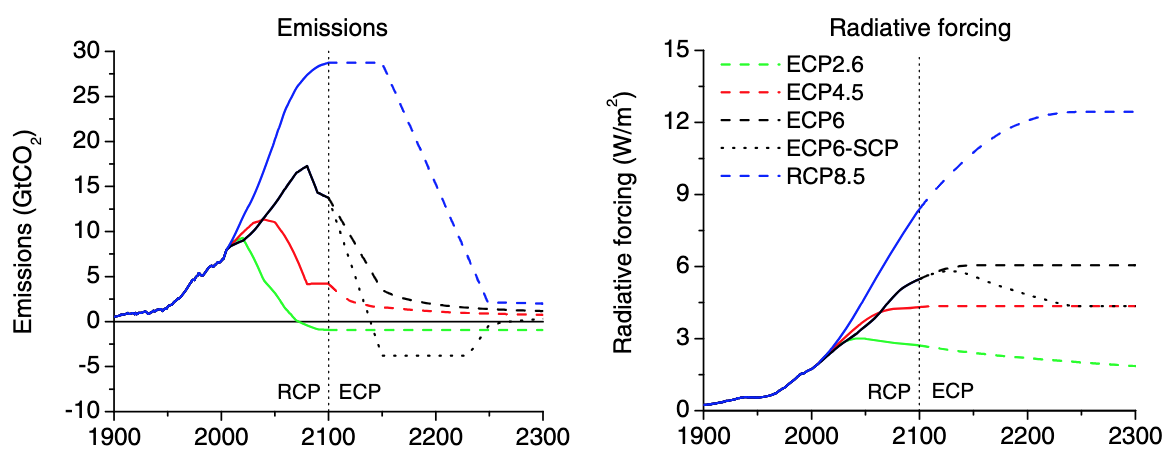"
/>

In [ ]:
# hide
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

SICOPOLIS_DIR = "/home/jelmar/Github/portfolio/sicopolis"

np.set_printoptions(precision=2, suppress=True)

sns.set_theme(
    style="darkgrid",
    palette="Set2",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.edgecolor": "k",
        "xtick.bottom": True,
        "ytick.left": True,
        "axes.linewidth": 1,
        "savefig.dpi": 300,
        "savefig.format": "pdf",
        "figure.constrained_layout.use": True,
    },
)

[CMIP5 monthly data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip5-monthly-single-levels?tab=overview) dataset.

Follow the instructions [here](https://cds.climate.copernicus.eu/api-how-to) to setup `cdsapi` and accept the Terms of Use for the dataset

It will generate the following request:


In [5]:
from pathlib import Path
import cdsapi

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

if not (DATA_DIR / "download.zip").exists():
    c = cdsapi.Client()

    c.retrieve(
        "projections-cmip5-monthly-single-levels",
        {
            "variable": "2m_temperature",
            "period": "200601-230012",
            "experiment": "rcp_8_5",
            "model": "ipsl_cm5a_lr",
            "ensemble_member": "r1i1p1",
            "format": "zip",
        },
        f"{DATA_DIR}/download.zip",
    )

Which, after unzipping:


In [6]:
!unzip -o $DATA_DIR/download.zip -d $DATA_DIR

Archive:  data/download.zip
  inflating: data/tas_Amon_IPSL-CM5A-LR_rcp85_r1i1p1_200601-230012.nc  


...gives us a netCDF file that looks a little like this.


In [7]:
from netCDF4 import Dataset

grp = Dataset(next(DATA_DIR.rglob("*.nc")).absolute())

print(*[(key, grp.variables[key].shape) for key in grp.variables.keys()], sep="\n")
grp.variables["tas"]

('time', (3540,))
('time_bnds', (3540, 2))
('lat', (96,))
('lat_bnds', (96, 2))
('lon', (96,))
('lon_bnds', (96, 2))
('height', ())
('tas', (3540, 96, 96))


<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    original_name: t2m
    cell_methods: time: mean (interval: 30 minutes)
    cell_measures: area: areacella
    history: 2011-08-16T21:57:47Z altered by CMOR: Treated scalar dimension: 'height'. 2011-08-16T21:57:47Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-08-16T21:57:48Z altered by CMOR: Inverted axis: lat.
    coordinates: height
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_rcp85_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_rcp85_r0i0p0.nc
unlimited dimensions: time
current shape = (3540, 96, 96)
filling on

## Creating input data

It is between latitudes 59° and 83°N, and longitudes 11° and 74°W.

This translates to lat: [59, 83], lon: [286, 349]


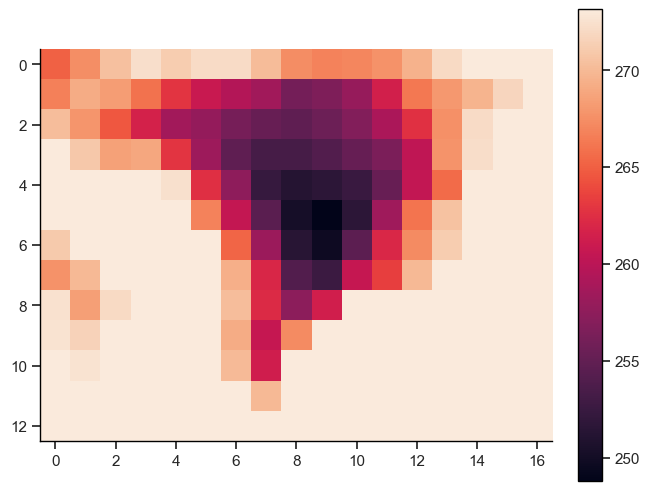

In [8]:
import matplotlib.pyplot as plt

[lat, lon] = [grp["lat"][:], grp["lon"][:]]
tas = grp["tas"][:, (lat >= 59) & (lat <= 83), (lon >= 286) & (lon <= 349)]
mask = tas[-1] < 273.15
x = tas[-1]

x[mask] = x[mask]
x[~mask] = 273.15

plt.imshow(x[::-1])
plt.grid(False)
plt.colorbar();

temps = [240.47 242.   243.91 ... 268.34 265.52 263.22]
yrs = [  0   0   0 ... 294 294 294]
chunked =
	[[240.47 242.   243.91 ... 254.38 248.07 241.32]
	 [238.61 239.11 243.87 ... 252.68 246.61 243.23]
	 [239.68 240.64 243.54 ... 251.35 243.64 242.59]
	 ...
	 [258.91 263.27 261.72 ... 269.57 265.38 262.05]
	 [258.28 257.18 258.25 ... 269.48 267.91 264.15]
	 [258.52 259.41 260.15 ... 268.34 265.52 263.22]]


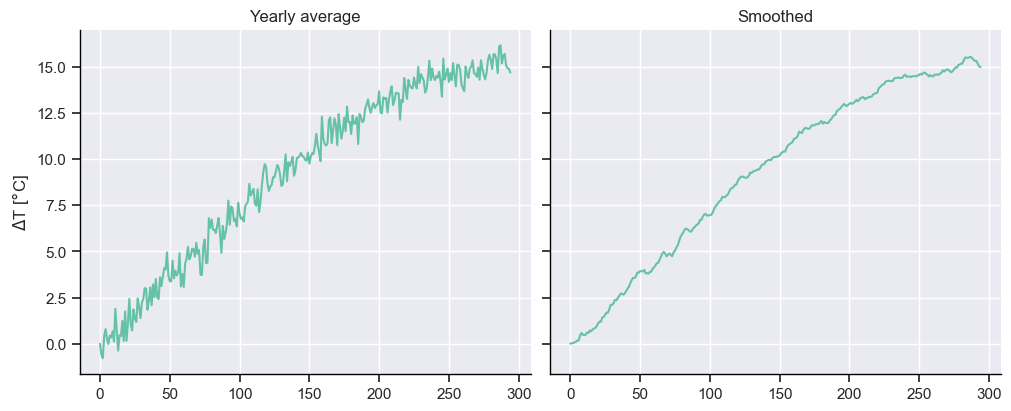

In [9]:
temps = np.mean(np.asarray(tas[:, mask]), axis=-1)
print(f"temps = {temps}")

yrs = np.array(grp.variables["time"][:] // 365).astype(int)
print(f"yrs = {yrs}")

chunked = np.array([temps[yrs == yr] for yr in np.unique(yrs)])
print(f"chunked =\n{"\n\t".join(["", *f"{chunked}".split("\n")])[1:]}")

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))


avgs = np.mean(chunked, axis=-1)
axes[0].plot(avgs - avgs[0])  # Kelvin difference == Celsius difference
axes[0].set_ylabel(r"$\Delta$T [$\degree$C]")
axes[0].set_title("Yearly average")


def smooth(x: np.ndarray, wlen: int) -> np.ndarray:
    w = np.ones(wlen, "d")
    padded = np.pad(x, (wlen // 2, wlen - 1 - wlen // 2), mode="edge")
    return np.convolve(padded, w / w.sum(), mode="valid")


smoothed_temps = smooth(avgs, 10)
axes[1].plot(smoothed_temps - smoothed_temps[0])
axes[1].set_title("Smoothed");

Nice! Now we have to write this out to a file that SICOPOLIS understands. `sico_in/general/grl_warming_scenario_rcp26.asc`. We'll take the temperature from there, too.


In [10]:
dt_2006 = 5.8161056e-01

time = 2006 + np.unique(yrs) - 1990
dtemps = (smoothed_temps - smoothed_temps[0]) + dt_2006
print(len(time), len(dtemps))

295 295


In [11]:
start, end = time[[0, -1]]
step = time[1] - time[0]

contents = f"""#  {start}  {step}  {end}
{"\n".join([f"  {yr}  {t}" for yr, t in zip(time, dtemps)])}

# --------------------------------------------------------------------------------
# Greenland surface temperature anomaly from RCP8.5 scenario for years 2006 - 2300
# Year (relative to 1990 CE) - Delta T [C]
# --------------------------------------------------------------------------------
"""

with open(f"{DATA_DIR}/grl_rcp85.dat", "w") as f:
    f.write(contents)

## Running the model


Now we can actually run the model.


a = annus; years in Latin.


`-a` doesn't take relative paths - so no `-a ./sico_in/...`, but `-a /home/user/sicopolis/sico_in/...`.


`(./sico.sh -f -m repo_grl20_b2_paleo21) >tmp/out_001.dat` (took ~1h12m)
`(./sico.sh -f -m grl20_rcp85 -a /home/jelmar/Github/portfolio/sicopolis/sico_out/repo_grl20_b2_paleo21) >tmp/out_001.dat`



<Note type="info">info</Note>

<Note type="warning">
  warning
</Note>

<Code
  language="fortran"
  oldFilename="sico_specs_repo_grl10_b2_future21_asmb.h"
  filename="sico_specs_grl20_rcp85.h"
  oldValue="file:./data/sico_specs_repo_grl10_b2_future21_asmb.h"
  value="file:./data/sico_specs_grl20_rcp85.h"
/>

## Processing output data


Output files will be in the folder `sico_out/grl20_rcp85` (or whatever name you gave to your specfile). An explanation of what these different files contain can be found [here](https://sicopolis.readthedocs.io/en/develop/getting_started.html#getting-started-output), but the gist of it is that the `.ser` or `_ser.nc` files contain scalar variables (`ser` meaning time series), the `.site` or `_site.nc` also contain (different) scalar variables sampled at particular *sites* (which are predefined and specific to your modeling domain), and the files that end in `0001.nc`, `0002.nc` etc. contain full 2D/3D fields (e.g. ice velocity or thickness). These fields are written out at the times we set on line 1322 of our specfile, so in our case it's once every 50 years.

Your directory should look something like this:

<FileTree
  items={[
    {
      name: "sico_out",
      items: [{
        name: "grl20_rcp85",
        items: [
          "grl20_rcp85.core",
          "out_grl20_rcp85.dat",
          "sico_specs_grl20_rcp85.h",
          "grl20_rcp85.log",
          "host_info.log",
          "grl20_rcp85_core.nc",
          "grl20_rcp85_ser.nc",
          "grl20_rcp850001.nc",
          "grl20_rcp850002.nc",
          "grl20_rcp850003.nc",
          "grl20_rcp850004.nc",
          "grl20_rcp850005.nc",
          "grl20_rcp850006.nc",
          "grl20_rcp850007.nc",
          "grl20_rcp85.ser",
        ]
      }]
    }
  ]}
/>

As a first sanity check, we'll get the surface temperature anomaly from the `grl20_rcp85_ser.nc` file to make sure that it corresponds to the input data we generated.

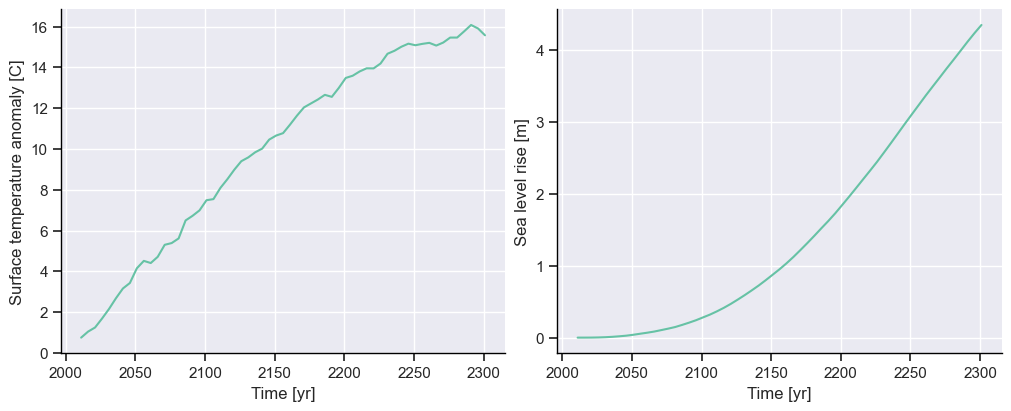

In [ ]:
sim_name = "grl20_rcp85"
root = f"{SICOPOLIS_DIR}/sico_out/{sim_name}"
start_year = 1990

ser = Dataset(f"{root}/{sim_name}_ser.nc")

[time, delta_ts, V_sle] = [ser.variables[x][:] for x in ["t", "delta_ts", "V_sle"]]
sle = (V_sle - V_sle[0]) * -1
time += start_year

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(time, delta_ts)
axes[1].plot(time, sle)

axes[0].set_ylabel("Surface temperature anomaly [C]")
axes[1].set_ylabel("Sea level rise [m]")

for ax in axes:
    ax.set_xlabel("Time [yr]")

<Collapsed>

In [ ]:
filenames = [f"{root}/{sim_name}{i:04}.nc" for i in range(2, 7 + 1)]
keys = ["as_perp", "H", "lat", "lon", "mask", "zs"]

data = {}
for filename in filenames:
    with Dataset(filename) as grp:
        year = start_year + grp.variables["time"][:]
        data[year] = {k: grp.variables[k][:] for k in keys}

In [ ]:
rho_ice = 916.7  # [kg/m^3]
SMBs = [(x["H"] > 0) * x["as_perp"] * rho_ice for x in data.values()]

zs = [np.ma.masked_where(~((x["mask"] == 0) | (x["mask"] == 1)), x["zs"]) for x in data.values()]
zs = [(x.min(), x.max()) for x in zs]

SMB_min, SMB_max = [np.min(SMBs), np.max(SMBs)]
z_min, z_max = [np.min(zs), np.max(zs)]

z_min, z_max

(-183.03348, 3267.3389)

KeyboardInterrupt: 

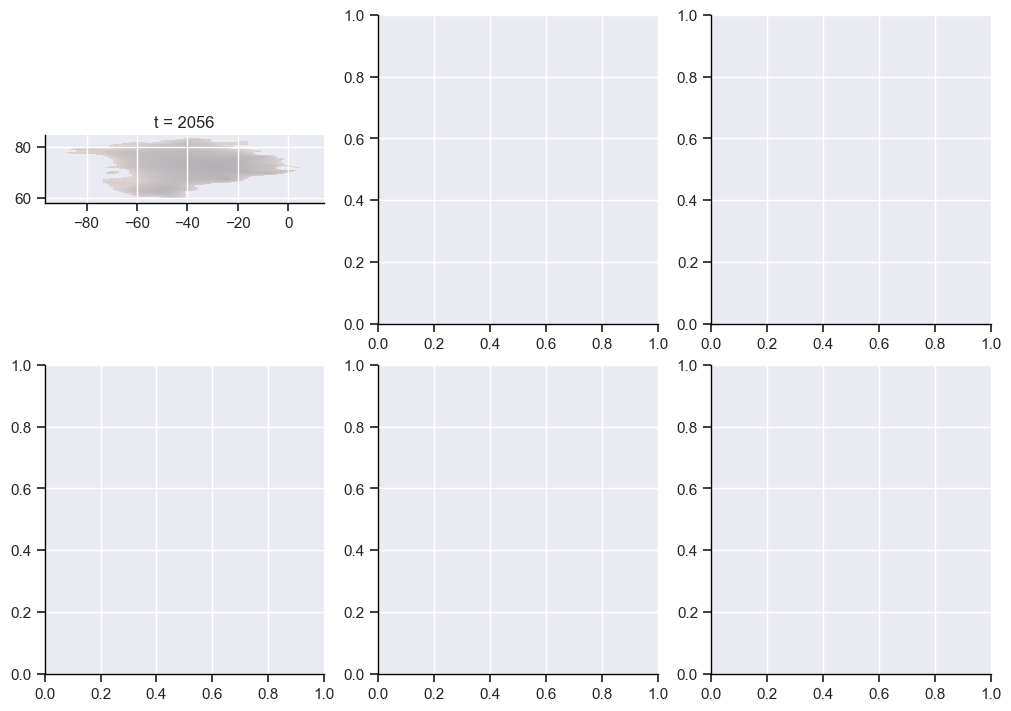

In [ ]:
from matplotlib.colors import hex2color, LinearSegmentedColormap

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), layout="constrained")
land_cmap = LinearSegmentedColormap.from_list("", [hex2color("#cda892"), hex2color("#352c26")])


for i, (year, vars) in enumerate(data.items()):
    ax = axes.flat[i]
    ax.set_title(f"t = {year:.0f}")

    as_perp, H, lat, lon, mask, zs = vars.values()
    land_mask = (mask == 0) | (mask == 1)
    SMB = (H > 0) * as_perp * 916.7

    x, y = [lon, lat]
    zs = zs.reshape(x.shape)
    land_zs = np.ma.masked_where(~land_mask, zs)

    extent = [x.min(), x.max(), y.min(), y.max()]
    kwargs = dict(extent=extent, origin="lower", alpha=0.3)

    # TODO: abs scale for these 2
    # _land = ax.contourf(
    #     x,
    #     y,
    #     land_zs,
    #     levels=np.arange(z_min, z_max + 100, step=100),
    #     antialiased=True,
    #     cmap=land_cmap,
    #     **kwargs,
    # )

    _land = ax.imshow(
        land_zs,
        cmap=land_cmap,
        **kwargs,
    )

    _elevation = ax.contour(
        # x,
        # y,
        land_zs,
        levels=np.arange(land_zs.min(), z_max + 1000, step=1000),
        # levels=[land_zs.min(), land_zs.min() + land_zs.max() / 2, land_zs.max()],
        linestyles="dashed",
        linewidths=0.75,
        colors="black",
        extend="both",
        **kwargs,
    )

    # ax.imshow(grp.variables["H"][:][::-1])

for ax in axes.flat:
    ax.set_aspect(4)
    ax.set_xticks([])
    ax.set_yticks([])

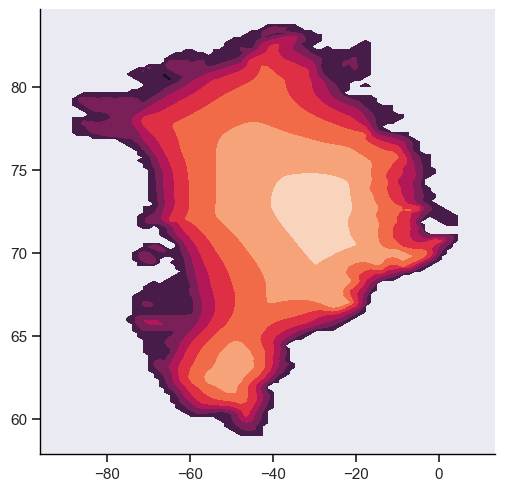

In [ ]:
x = list(data.values())[0]
plt.contourf(
    # x["lon"],
    # x["lat"],
    np.ma.masked_where(~((x["mask"] == 0) | (x["mask"] == 1)), x["zs"]),
    extent=[x["lon"].min(), x["lon"].max(), x["lat"].min(), x["lat"].max()],
    origin="lower",
)
plt.grid(False)
plt.gca().set_aspect(4)

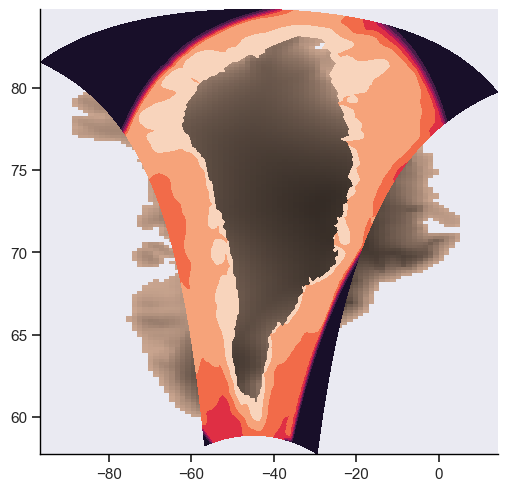

In [ ]:
plt.imshow(
    np.ma.masked_where(~((x["mask"] == 0) | (x["mask"] == 1)), x["zs"]),
    origin="lower",
    cmap=land_cmap,
    extent=[x["lon"].min(), x["lon"].max(), x["lat"].min(), x["lat"].max()],
)

plt.contourf(
    x["lon"],
    x["lat"],
    np.ma.masked_where(~((x["mask"] == 2) | (x["mask"] == 1)), x["zs"]),
    extent=[x["lon"].min(), x["lon"].max(), x["lat"].min(), x["lat"].max()],
    origin="lower",
)

plt.grid(False)
plt.gca().set_aspect(4)

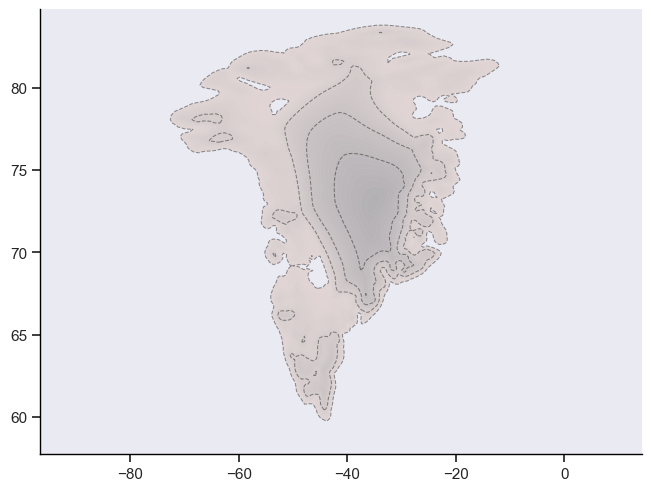

In [ ]:
extent = [x.min(), x.max(), y.min(), y.max()]

land = plt.contourf(
    x,
    y,
    zs,
    levels=np.arange(0, zs.max() + 100, step=100),
    antialiased=True,
    origin="lower",
    extent=extent,
    cmap=cmap,
    alpha=0.3,
    zorder=1,
)

elevation = plt.contour(
    x,
    y,
    zs,
    levels=np.arange(0, H.max() + 750, step=750),
    linestyles="dashed",
    linewidths=0.75,
    origin="lower",
    colors="black",
    extent=extent,
    alpha=0.4,
)

plt.gca().set_aspect("auto")
plt.grid(False)

</Collapsed>

## Conclusions